In [33]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [35]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
import warnings,os
from skimage import io, transform
from PIL import Image
import numpy as np
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [37]:
class PaveDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root = Path(root_dir)
        self.image_dir = os.path.join(self.root,'images')
        self.mask_dir = os.path.join(self.root,'masks')
        self.images = os.listdir(self.image_dir)
        self.transform = transform

    def __len__(self):
        # returns the length of the dataset
        return len(self.images)

    def __getitem__(self, idx):

    #     # preprocess and transformations
    #     # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = io.imread(image_path)
        # image = np.array(Image.open(image_path).convert("RGB"))
        # image = image.permute(2,0,1)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

    #     label = torch.tensor(self.class_label[idx])

    #     sample = {'image': image_data, 'label': label}
    #     scale = Rescale((256,256))
    #     sample = scale(sample)
    #     # print (sample['image'].shape)
    #     img = sample['image'].permute(2,0,1)
    #     ## h,w,c --> c, h, w
    #     ## 0,1,2 --> 2, 0, 1
    #     # print (img.shape)
        # return {'image':img,'label':torch.tensor(label,dtype=torch.float32)}
        return {'image':image,'mask':mask}

In [38]:
pwd

'/content'

In [39]:
pave_dataset = PaveDataset('/content/drive/MyDrive/3semester/8160/unet/train_')

In [26]:
for idx,data in enumerate(pave_dataset):
    print (idx,data['image'].permute(2,0,1).shape)

    if idx==1:
        break

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [40]:
train_loader = DataLoader(
        pave_dataset,
        batch_size=8,
        num_workers=4,
        pin_memory=True,
        shuffle=True,
    )
#batch_size=8

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [42]:
n_epochs = 4
losses = []
mean_loss = []
for it in tqdm(range(n_epochs)):
    for i_batch, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()
#4, 3, 448, 448
        outputs = model(sample_batched['image'].permute(0,3,1,2).float().to(device))
        targets = sample_batched['mask'].float().unsqueeze(1).to(device)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    mean_loss.append(np.mean(losses))
    print (np.mean(losses))


 25%|██▌       | 1/4 [00:07<00:21,  7.01s/it]

-0.5810262531042099


 50%|█████     | 2/4 [00:13<00:13,  6.97s/it]

-2.4090397998690607


 75%|███████▌  | 3/4 [00:21<00:07,  7.03s/it]

-3.746713649233182


100%|██████████| 4/4 [00:28<00:00,  7.02s/it]

-5.12993481978774


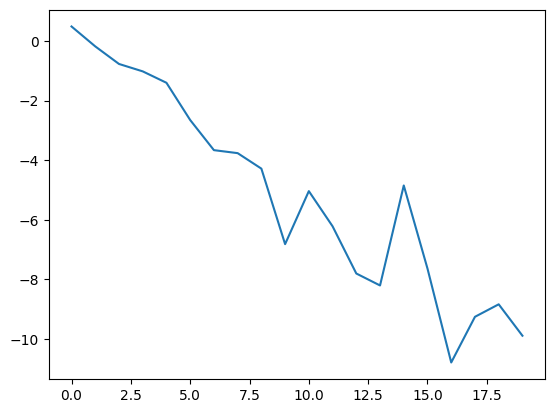

In [43]:
plt.plot(losses)

In [46]:
def evaluation(model,img_path):
    model.eval()
    img = io.imread(img_path)
    fig = plt.figure(figsize=(20,30))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(img)

    img_ = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).float().to(device)
    # print(img.shape, img_.shape)
    outputs = torch.sigmoid(model(img_))
    #threshold 0.5, increase
    outputs = (outputs>0.5).float()
    ax = plt.subplot(1, 3, 2)
    target = outputs.squeeze(0).reshape((448,448)).detach().cpu()
    plt.imshow(target)

    ax = plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='gray')
    plt.imshow(target, cmap='jet', alpha=0.7*(target>0))

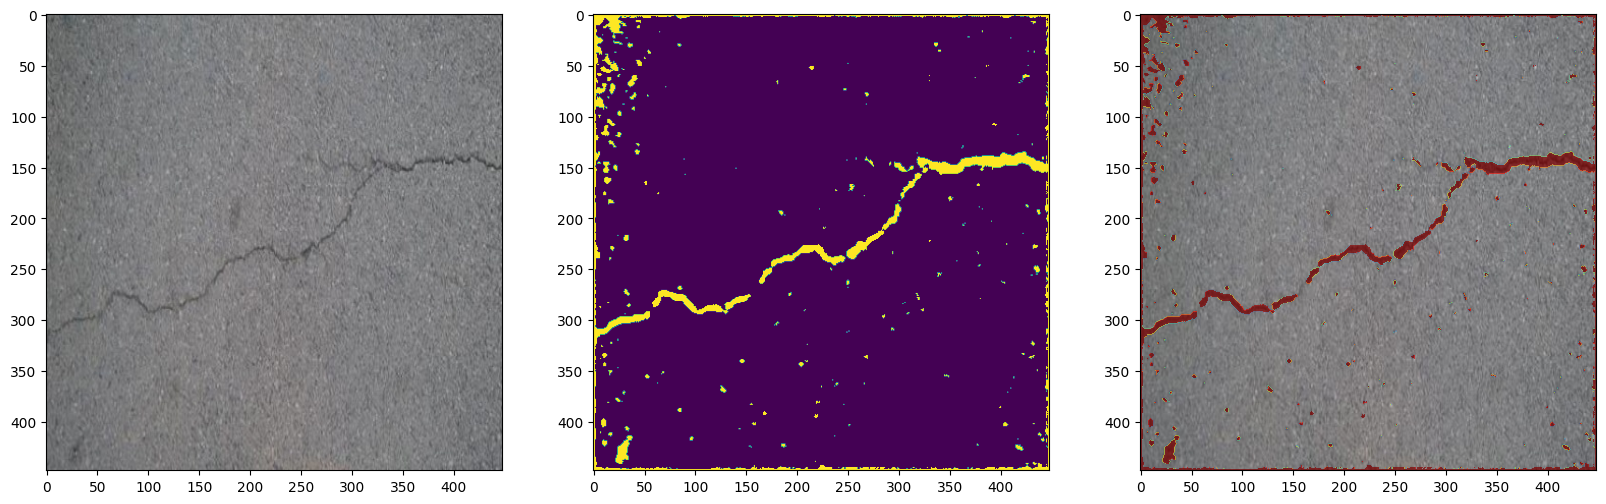

In [47]:
img_path ='/content/drive/MyDrive/3semester/8160/unet/train_/images/CFD_020.jpg'
evaluation(model,img_path)

In [ ]:
# for i, sample in enumerate(train_loader):
#   print(i, sample['image'].permute(0,3,1,2).dtype, sample['mask'].float().unsqueeze(1).shape)
#   if i == 1:
#     break

In [48]:
x = torch.randn((3, 1, 161, 161))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)